# This Jupyter Notebook Runs the Optimization for the Technical Indicator Features incorporated with my S&P500 Data

In [70]:
# general imports:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt


# get data:
# Download Data
print("Downloading SPY Price Data...")
spy_ohlc_df = yf.download('SPY', start='1993-02-01', end='2022-09-30')
# index are the current Daates, so set df["Dates"] = index
spy_ohlc_df["Dates"] = spy_ohlc_df.index
spy_ohlc_df.reset_index(drop=True, inplace=True)  # reset the index and drop, inplace
spy_ohlc_df = spy_ohlc_df.drop(["Adj Close"], axis=1)  # drop Adj Close - not of interest

[*********************100%***********************]  1 of 1 completed


In [71]:
def calc_target_vars(df, column="Close", period=1):
    """
    This Function Calculates the Target Variables Next Day 'Percent Next Day', 
    'Price Next Day', and 'next_day_directions' for a column name and period.
    
    :param df: a Pandas DataFrame with the specified column
    :param column: default 'Close', the column to run target variable calculations
    :param period: default 1, the period in the future to calculate the target variable 
    calculations
    :return: next_day_percent_change_vals, next_day_prices, next_day_directions, which are all
    lists of the target variable values
    """
    next_day_percent_change_vals = []
    next_day_prices = []
    next_day_directions = []
    for i in range(0, len(df)):
        if i == len(df) - 1:
            break
        current_price = df[column].iloc[i]
        next_price = df[column].iloc[i + period]
        # percent change:
        percent_change_of_next_day = (next_price - current_price) / current_price
        next_day_percent_change_vals.append(percent_change_of_next_day)
        # next day price:
        next_day_prices.append(next_price)
        # next day direction:
        if next_price > current_price:
            next_day_directions.append(1)
        else:
            next_day_directions.append(0)
            
    # Can't Calculate the next day target vars for final value:
    next_day_percent_change_vals.append(np.nan)
    next_day_prices.append(np.nan)
    next_day_directions.append(np.nan)
    
    return next_day_percent_change_vals, next_day_prices, next_day_directions

In [72]:
# calculate the target variables:
percent_next_day, price_next_day, direction_next_day = calc_target_vars(spy_ohlc_df)

# add 'Percent Next Day':
spy_ohlc_df['Percent Next Day'] = percent_next_day

# add 'Price Next Day':
spy_ohlc_df['Price Next Day'] = price_next_day

# add 'Direction Next Day':
spy_ohlc_df['Direction Next Day'] = direction_next_day

### Momentum Indicators:

In [78]:
# import indicators and correlation metric needed for momentum optimization:

from ta.momentum import AwesomeOscillatorIndicator, KAMAIndicator, \
    PercentagePriceOscillator, ROCIndicator, RSIIndicator, StochRSIIndicator, \
    StochasticOscillator, TSIIndicator


from scipy.stats import pearsonr

In [67]:
train_index = int(len(spy_ohlc_df) * 0.6)

Awesome Oscillator:
Best Period1: 3
Best Period2: 2
Best Corr: -0.012149708002323258


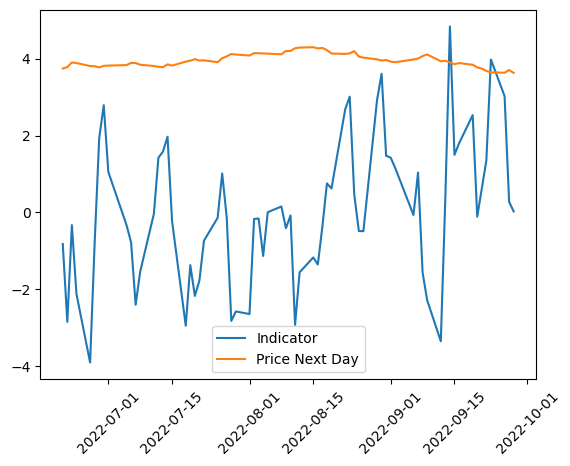

In [68]:
# AwesomeOscillatorIndicator
best_period1 = None
best_period2 = None
best_corr = -np.inf
# optimize Indicator
for i in range(2, 100):
    for j in range(2, 100):
        if i <= j:
            continue
        spy_ohlc_df['indicator'] = AwesomeOscillatorIndicator(low=spy_ohlc_df["Low"], 
                                                              high=spy_ohlc_df["High"], 
                                                              window1=i, 
                                                              window2=j).awesome_oscillator()
        indicator = list(spy_ohlc_df['indicator'].iloc[i:train_index])
        next_day_returns_list = list(spy_ohlc_df['Price Next Day'].iloc[i:train_index])
        result = pearsonr(indicator, next_day_returns_list)
        corr = result.statistic
        if corr > best_corr:
            best_corr = corr
            best_period1 = i
            best_period2 = j
            
print("Awesome Oscillator:")
print("Best Period1:", best_period1)
print("Best Period2:", best_period2)
print("Best Corr:", best_corr)

spy_ohlc_df['indicator'] = AwesomeOscillatorIndicator(low=spy_ohlc_df["Low"],
                            high=spy_ohlc_df["High"], window1=best_period1,
                            window2=best_period2).awesome_oscillator()

plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], spy_ohlc_df['indicator'].iloc[7400:-1], 
         label="Indicator")
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], 
         spy_ohlc_df['Price Next Day'].iloc[7400:-1] / 100, label="Price Next Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

KAMA:
Best Window: 2
Best Pow1: 2
Best Pow2: 2
Best Corr: 0.9988680253954969


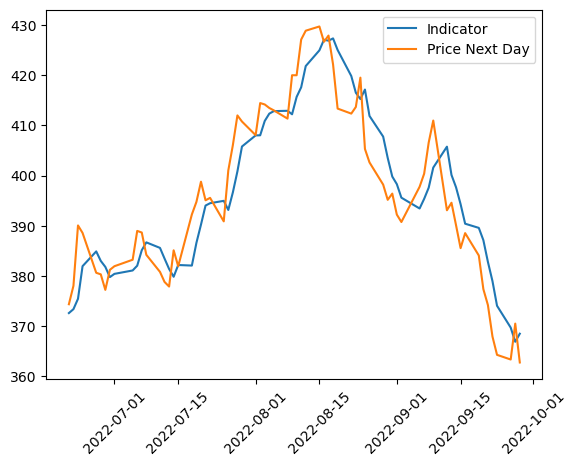

In [73]:
# KAMAIndicator
best_period1 = None
best_period2 = None
best_period3 = None
best_corr = -np.inf
# optimize Indicator
for i in range(2, 10):
    for j in range(2, 10):
        for k in range(2, 10):
            spy_ohlc_df['indicator'] = KAMAIndicator(close=spy_ohlc_df["Close"], 
                                                     window=i, pow1=j, pow2=k).kama()
            indicator = list(spy_ohlc_df['indicator'].iloc[i:train_index])
            next_day_returns_list = list(spy_ohlc_df['Price Next Day'].iloc[i:train_index])
            result = pearsonr(indicator, next_day_returns_list)
            corr = result.statistic
            if corr > best_corr:
                best_corr = corr
                best_period1 = i
                best_period2 = j
                best_period3 = k
            
print("KAMA:")
print("Best Window:", best_period1)
print("Best Pow1:", best_period2)
print("Best Pow2:", best_period3)
print("Best Corr:", best_corr)

spy_ohlc_df['indicator'] = KAMAIndicator(close=spy_ohlc_df["Close"], window=best_period1, 
                                         pow1=best_period2, pow2=best_period3).kama()

plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], spy_ohlc_df['indicator'].iloc[7400:-1], 
         label="Indicator")
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], 
         spy_ohlc_df['Price Next Day'].iloc[7400:-1], label="Price Next Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

/Users/henrypasts/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


PercentagePriceOscillator
Best Window Slow: 3
Best Window Fast: 2
Best Window Sign: 2
Best Corr: 0.0022491196780702505


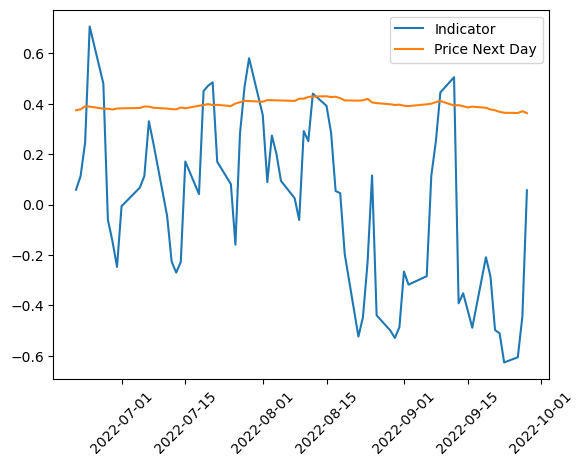

In [74]:
# PercentagePriceOscillator
best_period1 = None
best_period2 = None
best_period3 = None
best_corr = -np.inf
# optimize Indicator
for i in range(2, 20):
    for j in range(2, 20):
        for k in range(2, 20):
            if j > i or k > j:
                continue
            spy_ohlc_df['indicator'] = PercentagePriceOscillator(close=spy_ohlc_df["Close"],
                                                                 window_slow=i, 
                                                                 window_fast=j, 
                                                                 window_sign=k).ppo()
            indicator = list(spy_ohlc_df['indicator'].iloc[i:train_index])
            next_day_returns_list = list(spy_ohlc_df['Price Next Day'].iloc[i:train_index])
            result = pearsonr(indicator, next_day_returns_list)
            corr = result.statistic
            if corr > best_corr:
                best_corr = corr
                best_period1 = i
                best_period2 = j
                best_period3 = k
            
print("PercentagePriceOscillator")
print("Best Window Slow:", best_period1)
print("Best Window Fast:", best_period2)
print("Best Window Sign:", best_period3)
print("Best Corr:", best_corr)

spy_ohlc_df['indicator'] = PercentagePriceOscillator(close=spy_ohlc_df["Close"],
                                                     window_slow=best_period1,
                                                     window_fast=best_period2, 
                                                     window_sign=best_period1).ppo()

plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], spy_ohlc_df['indicator'].iloc[7400:-1], 
         label="Indicator")
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], 
         spy_ohlc_df['Price Next Day'].iloc[7400:-1] / 1000, label="Price Next Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

ROC:
Best Window: 200
Best Corr: 0.017147888917284575


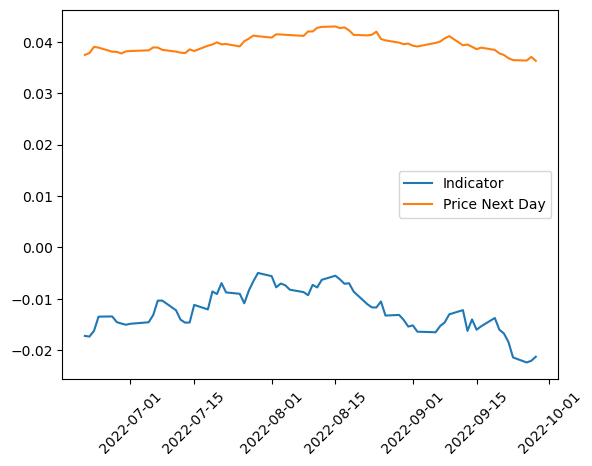

In [75]:
# ROC
best_period1 = None
best_corr = -np.inf
# optimize Indicator
for i in range(2, 201):
    spy_ohlc_df['indicator'] = ROCIndicator(close=spy_ohlc_df["Close"], window=i).roc()
    indicator = list(spy_ohlc_df['indicator'].iloc[i:train_index])
    next_day_returns_list = list(spy_ohlc_df['Price Next Day'].iloc[i:train_index])
    result = pearsonr(indicator, next_day_returns_list)
    corr = result.statistic
    if corr > best_corr:
        best_period1 = i
        best_corr = corr
            
print("ROC:")
print("Best Window:", best_period1)
print("Best Corr:", best_corr)

spy_ohlc_df['indicator'] = ROCIndicator(close=spy_ohlc_df["Close"], window=best_period1).roc()
spy_ohlc_df['indicator'] = spy_ohlc_df['indicator'] / 1000

plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], spy_ohlc_df['indicator'].iloc[7400:-1], 
         label="Indicator")
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], 
         spy_ohlc_df['Price Next Day'].iloc[7400:-1] / 10000, label="Price Next Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

RSI:
Best Window: 200
Best Corr: 0.16585004175591106


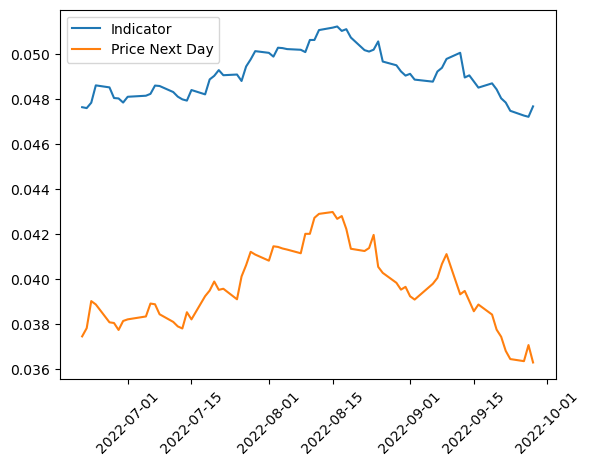

In [16]:
#RSIIndicator
best_period1 = None
best_corr = -np.inf
# optimize Indicator
for i in range(2, 201):
    spy_ohlc_df['indicator'] = RSIIndicator(close=spy_ohlc_df["Close"], window=i).rsi()
    indicator = list(spy_ohlc_df['indicator'].iloc[i:train_index])
    next_day_returns_list = list(spy_ohlc_df['Price Next Day'].iloc[i:train_index])
    result = pearsonr(indicator, next_day_returns_list)
    corr = result.statistic
    if corr > best_corr:
        best_period1 = i
        best_corr = corr
            
print("RSI:")
print("Best Window:", best_period1)
print("Best Corr:", best_corr)

spy_ohlc_df['indicator'] = RSIIndicator(close=spy_ohlc_df["Close"], window=best_period1).rsi()
spy_ohlc_df['indicator'] = spy_ohlc_df['indicator'] / 1000

plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], spy_ohlc_df['indicator'].iloc[7400:-1], 
         label="Indicator")
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], 
         spy_ohlc_df['Price Next Day'].iloc[7400:-1] / 10000, label="Price Next Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

StochRSIIndicator
Best Window: 19
Best Smooth1: 19
Best Corr: 0.03058108081423365


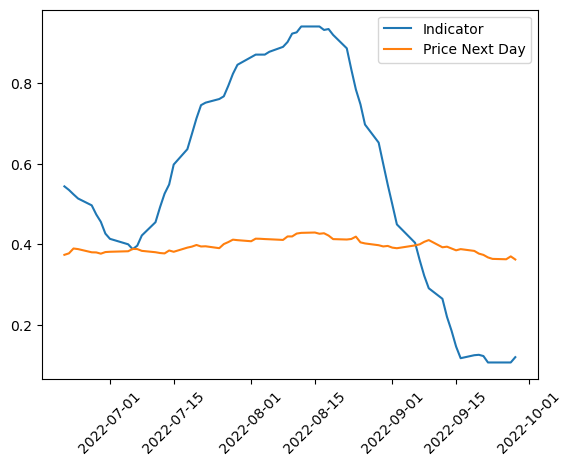

In [196]:
# StochRSIIndicator
best_period1 = None
best_period2 = None
best_corr = -np.inf
# optimize Indicator
for i in range(3, 20):
    for j in range(4, 20):
        if j < i:
            continue
        spy_ohlc_df['indicator'] = StochRSIIndicator(close=spy_ohlc_df["Close"], window=i, 
                                                     smooth1=j, 
                                                     fillna=True).stochrsi_k()
        indicator = np.array(list(spy_ohlc_df['indicator'].iloc[i + j + 3:train_index]))
        next_day_returns_list = list(spy_ohlc_df['Price Next Day'].iloc[i + j + 
                                                                        3:train_index])
        result = pearsonr(indicator, next_day_returns_list)
        corr = result.statistic
        if corr > best_corr:
            best_corr = corr
            best_period1 = i
            best_period2 = j
            
print("StochRSIIndicator")
print("Best Window:", best_period1)
print("Best Smooth1:", best_period2)
print("Best Corr:", best_corr)

spy_ohlc_df['indicator'] = StochRSIIndicator(close=spy_ohlc_df["Close"],
                                                     window=best_period1,
                                                     smooth1=best_period2).stochrsi_k()

plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], spy_ohlc_df['indicator'].iloc[7400:-1], 
         label="Indicator")
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], 
         spy_ohlc_df['Price Next Day'].iloc[7400:-1] / 1000, label="Price Next Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

StochasticOscillator
Best Window: 4
Best Corr: -0.01727117767650073


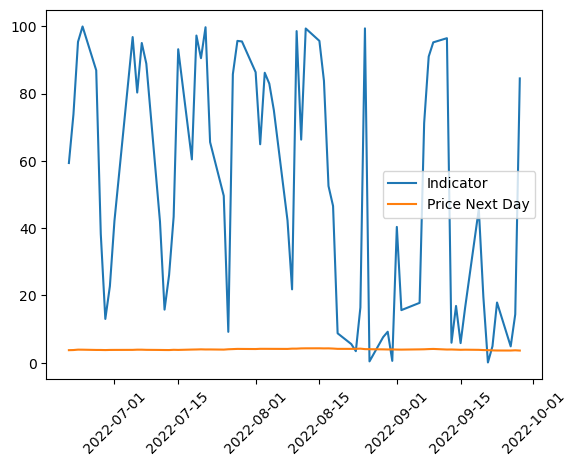

In [194]:
# StochasticOscillator
best_period1 = None
best_corr = -np.inf
# optimize Indicator
for i in range(3, 200):
        spy_ohlc_df['indicator'] = StochasticOscillator(close=spy_ohlc_df["Close"],
                                                        high=spy_ohlc_df["High"],
                                                        low=spy_ohlc_df["Low"],
                                                        window=i).stoch()
        indicator = np.array(list(spy_ohlc_df['indicator'].iloc[i:train_index]))
        next_day_returns_list = list(spy_ohlc_df['Price Next Day'].iloc[i:train_index])
        result = pearsonr(indicator, next_day_returns_list)
        corr = result.statistic
        if corr > best_corr:
            best_corr = corr
            best_period1 = i
            best_period2 = j
            
print("StochasticOscillator")
print("Best Window:", best_period1)
print("Best Corr:", best_corr)

spy_ohlc_df['indicator'] = StochasticOscillator(close=spy_ohlc_df["Close"],
                                                        high=spy_ohlc_df["High"],
                                                        low=spy_ohlc_df["Low"],
                                                        window=best_period1).stoch()

plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], spy_ohlc_df['indicator'].iloc[7400:-1], 
         label="Indicator")
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], 
         spy_ohlc_df['Price Next Day'].iloc[7400:-1] / 100, label="Price Next Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

TSI Indicator
Best Window: 3
Best Smooth1: 4
Best Corr: -0.01814600677063743


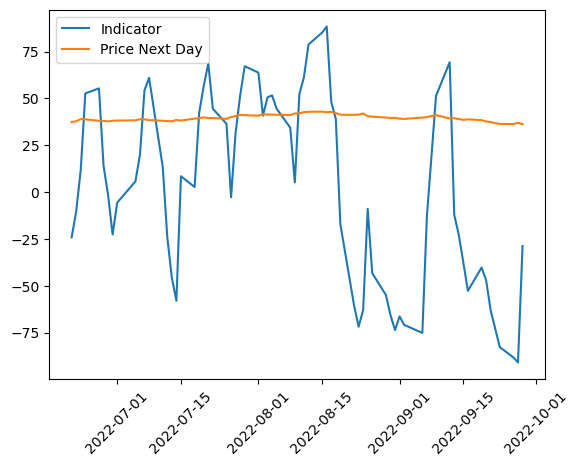

In [195]:
# TSIIndicator
best_period1 = None
best_period2 = None
best_corr = -np.inf
# optimize Indicator
for i in range(3, 20):
    for j in range(4, 20):
#         if j < i:
#             continue
        spy_ohlc_df['indicator'] = TSIIndicator(close=spy_ohlc_df["Close"], window_slow=i, 
                                                     window_fast=j).tsi()
        indicator = np.array(list(spy_ohlc_df['indicator'].iloc[i+j:train_index]))
        next_day_returns_list = list(spy_ohlc_df['Price Next Day'].iloc[i + j:train_index])
        result = pearsonr(indicator, next_day_returns_list)
        corr = result.statistic
        if corr > best_corr:
            best_corr = corr
            best_period1 = i
            best_period2 = j
            
print("TSI Indicator")
print("Best Window:", best_period1)
print("Best Smooth1:", best_period2)
print("Best Corr:", best_corr)

spy_ohlc_df['indicator'] = TSIIndicator(close=spy_ohlc_df["Close"],
                                                     window_slow=best_period1,
                                                     window_fast=best_period2).tsi()

plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], spy_ohlc_df['indicator'].iloc[7400:-1], 
         label="Indicator")
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], 
         spy_ohlc_df['Price Next Day'].iloc[7400:-1] / 10, label="Price Next Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Volume Indicators:

In [150]:
# import indicator needed for volume optimization:

from ta.volume import AccDistIndexIndicator, ChaikinMoneyFlowIndicator, \
    EaseOfMovementIndicator, ForceIndexIndicator, MFIIndicator, \
     NegativeVolumeIndexIndicator, OnBalanceVolumeIndicator, \
        VolumePriceTrendIndicator, VolumeWeightedAveragePrice

0.37655097197301285


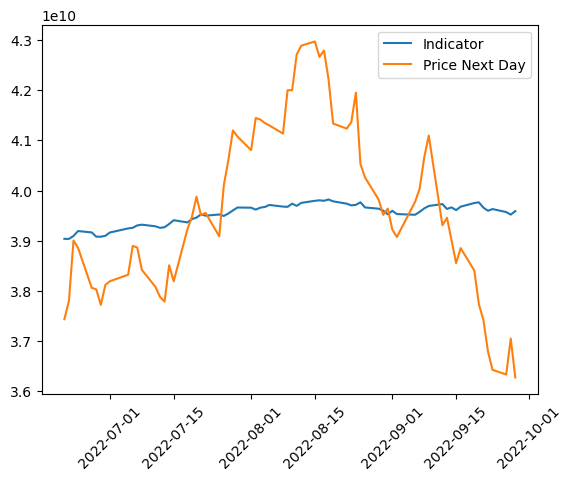

In [104]:
# AccDistIndexIndicator
spy_ohlc_df['indicator'] = AccDistIndexIndicator(close=spy_ohlc_df["Close"],
                                                high=spy_ohlc_df["High"],
                                                low=spy_ohlc_df["Low"],
                                                volume=spy_ohlc_df["Volume"]).acc_dist_index()
indicator = list(spy_ohlc_df['indicator'].iloc[0:train_index])
next_day_returns_list = list(spy_ohlc_df['Price Next Day'].iloc[0:train_index])
result = pearsonr(indicator, next_day_returns_list)
corr = result.statistic
print(corr)

plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], spy_ohlc_df['indicator'].iloc[7400:-1], 
         label="Indicator")
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], 
         spy_ohlc_df['Price Next Day'].iloc[7400:-1] * 100000000, label="Price Next Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

-0.14833800795959076


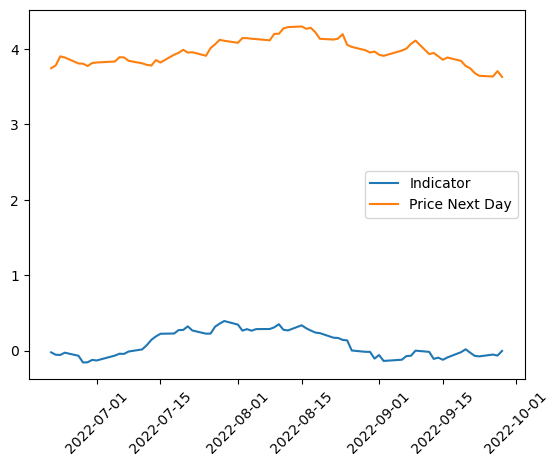

In [118]:
# ChaikinMoneyFlow
spy_ohlc_df['indicator'] = ChaikinMoneyFlowIndicator(close=spy_ohlc_df["Close"],
                                            high=spy_ohlc_df["High"],
                                            low=spy_ohlc_df["Low"],
                                            volume=spy_ohlc_df["Volume"],
                                                    fillna=True).chaikin_money_flow()
indicator = list(spy_ohlc_df['indicator'].iloc[0:train_index])
next_day_returns_list = list(spy_ohlc_df['Price Next Day'].iloc[0:train_index])
result = pearsonr(indicator, next_day_returns_list)
corr = result.statistic
print(corr)

plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], spy_ohlc_df['indicator'].iloc[7400:-1], 
         label="Indicator")
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], 
         spy_ohlc_df['Price Next Day'].iloc[7400:-1] / 100, label="Price Next Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

-0.03436351224371457


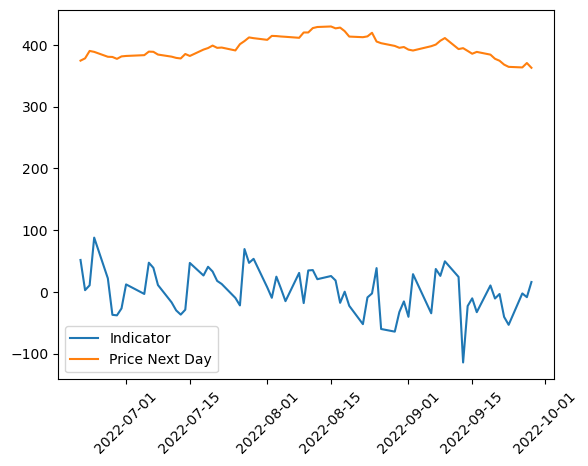

In [120]:
# EaseOfMovementIndicator
spy_ohlc_df['indicator'] = EaseOfMovementIndicator(high=spy_ohlc_df["High"],
                                            low=spy_ohlc_df["Low"],
                                            volume=spy_ohlc_df["Volume"],
                                                    fillna=True).ease_of_movement()
indicator = list(spy_ohlc_df['indicator'].iloc[0:train_index])
next_day_returns_list = list(spy_ohlc_df['Price Next Day'].iloc[0:train_index])
result = pearsonr(indicator, next_day_returns_list)
corr = result.statistic
print(corr)

plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], spy_ohlc_df['indicator'].iloc[7400:-1], 
         label="Indicator")
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], 
         spy_ohlc_df['Price Next Day'].iloc[7400:-1], label="Price Next Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

-0.017999018956117493


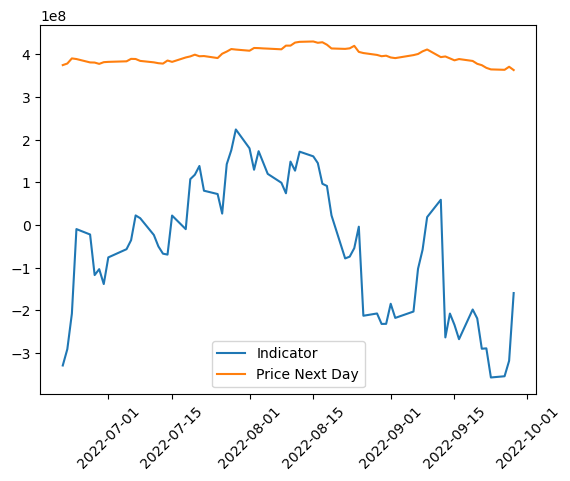

In [126]:
# ForceIndexIndicator
spy_ohlc_df['indicator'] =  ForceIndexIndicator(close=spy_ohlc_df["Close"],
                                            volume=spy_ohlc_df["Volume"], 
                                                fillna=True).force_index()
indicator = list(spy_ohlc_df['indicator'].iloc[0:train_index])
next_day_returns_list = list(spy_ohlc_df['Price Next Day'].iloc[0:train_index])
result = pearsonr(indicator, next_day_returns_list)
corr = result.statistic
print(corr)

plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], spy_ohlc_df['indicator'].iloc[7400:-1], 
         label="Indicator")
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], 
         spy_ohlc_df['Price Next Day'].iloc[7400:-1] * 1000000, label="Price Next Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

MFI Indicator
Best Window: 2
Best Corr: -0.019889642605183513


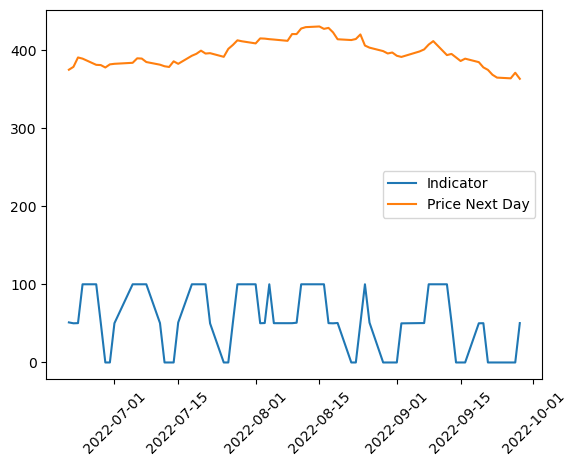

In [154]:
# MFIIndicator
best_period1 = None
best_corr = -np.inf
# optimize Indicator
for i in range(2, 200):
        spy_ohlc_df['indicator'] = MFIIndicator(close=spy_ohlc_df["Close"],
                                                        high=spy_ohlc_df["High"],
                                                        low=spy_ohlc_df["Low"],
                                                        volume=spy_ohlc_df["Low"],
                                                        window=i).money_flow_index()
        indicator = np.array(list(spy_ohlc_df['indicator'].iloc[i:train_index]))
        next_day_returns_list = list(spy_ohlc_df['Price Next Day'].iloc[i:train_index])
        result = pearsonr(indicator, next_day_returns_list)
        corr = result.statistic
        if corr > best_corr:
            best_corr = corr
            best_period1 = i
            
print("MFI Indicator")
print("Best Window:", best_period1)
print("Best Corr:", best_corr)

spy_ohlc_df['indicator'] = MFIIndicator(close=spy_ohlc_df["Close"],
                                                    high=spy_ohlc_df["High"],
                                                    low=spy_ohlc_df["Low"],
                                                    volume=spy_ohlc_df["Low"],
                                                    window=best_period1).money_flow_index()

plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], spy_ohlc_df['indicator'].iloc[7400:-1], 
         label="Indicator")
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], 
         spy_ohlc_df['Price Next Day'].iloc[7400:-1], label="Price Next Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

0.41546330934329184


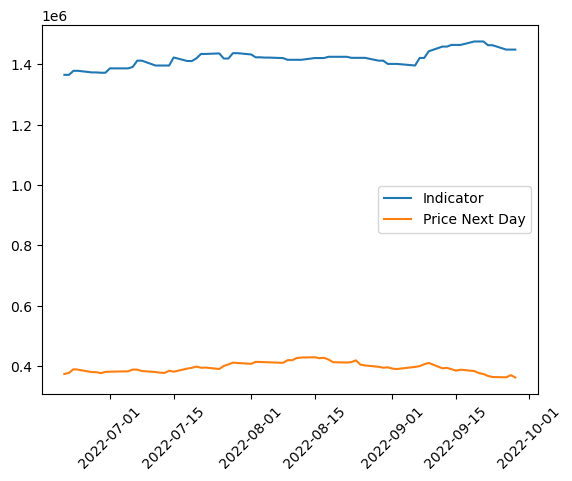

In [137]:
# NegativeVolumeIndexIndicator
spy_ohlc_df['indicator'] =   NegativeVolumeIndexIndicator(close=spy_ohlc_df["Close"],
                                            volume=spy_ohlc_df["Volume"], 
                                                fillna=True).negative_volume_index()
indicator = list(spy_ohlc_df['indicator'].iloc[0:train_index])
next_day_returns_list = list(spy_ohlc_df['Price Next Day'].iloc[0:train_index])
result = pearsonr(indicator, next_day_returns_list)
corr = result.statistic
print(corr)

plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], spy_ohlc_df['indicator'].iloc[7400:-1], 
         label="Indicator")
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], 
         spy_ohlc_df['Price Next Day'].iloc[7400:-1] * 1000, label="Price Next Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

0.45727684770512933


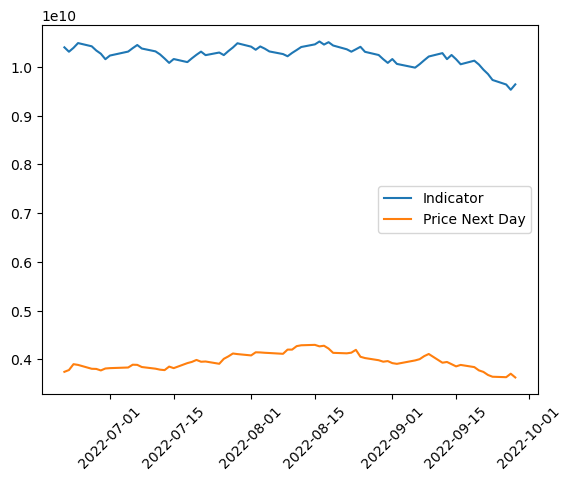

In [141]:
# OnBalanceVolumeIndicator
spy_ohlc_df['indicator'] = OnBalanceVolumeIndicator(close=spy_ohlc_df["Close"],
                                            volume=spy_ohlc_df["Volume"], 
                                                fillna=True).on_balance_volume()
indicator = list(spy_ohlc_df['indicator'].iloc[0:train_index])
next_day_returns_list = list(spy_ohlc_df['Price Next Day'].iloc[0:train_index])
result = pearsonr(indicator, next_day_returns_list)
corr = result.statistic
print(corr)

plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], spy_ohlc_df['indicator'].iloc[7400:-1], 
         label="Indicator")
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], 
         spy_ohlc_df['Price Next Day'].iloc[7400:-1] * 10000000, label="Price Next Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

-0.00224247398313746


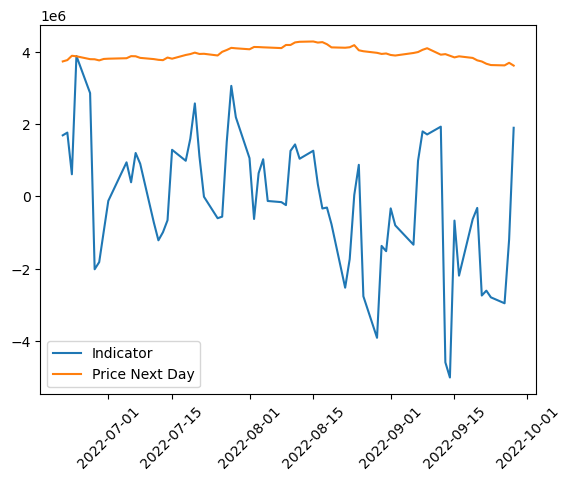

In [147]:
# VolumePriceTrendIndicator
spy_ohlc_df['indicator'] = VolumePriceTrendIndicator(close=spy_ohlc_df["Close"],
                                            volume=spy_ohlc_df["Volume"], 
                                                fillna=True).volume_price_trend()
indicator = list(spy_ohlc_df['indicator'].iloc[0:train_index])
next_day_returns_list = list(spy_ohlc_df['Price Next Day'].iloc[0:train_index])
result = pearsonr(indicator, next_day_returns_list)
corr = result.statistic
print(corr)

plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], spy_ohlc_df['indicator'].iloc[7400:-1], 
         label="Indicator")
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], 
         spy_ohlc_df['Price Next Day'].iloc[7400:-1] * 10000, label="Price Next Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

VolumeWeightedAveragePrice Indicator
Best Window: 1
Best Corr: 0.9990656849525464


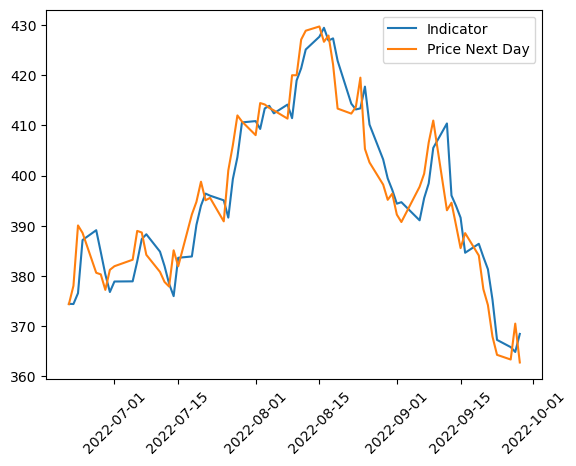

In [182]:
# VolumeWeightedAveragePrice
best_period1 = None
best_corr = -np.inf
# optimize Indicator
for i in range(1, 200):
        spy_ohlc_df['indicator'] = VolumeWeightedAveragePrice(close=spy_ohlc_df["Close"],
                                                    high=spy_ohlc_df["High"],
                                                    low=spy_ohlc_df["Low"],
                                                    volume=spy_ohlc_df["Low"],
                                                    window=i).volume_weighted_average_price()
        indicator = np.array(list(spy_ohlc_df['indicator'].iloc[i:train_index]))
        next_day_returns_list = list(spy_ohlc_df['Price Next Day'].iloc[i:train_index])
        result = pearsonr(indicator, next_day_returns_list)
        corr = result.statistic
        if corr > best_corr:
            best_corr = corr
            best_period1 = i
            
print("VolumeWeightedAveragePrice Indicator")
print("Best Window:", best_period1)
print("Best Corr:", best_corr)

spy_ohlc_df['indicator'] = VolumeWeightedAveragePrice(close=spy_ohlc_df["Close"],
                                        high=spy_ohlc_df["High"],
                                        low=spy_ohlc_df["Low"],
                                        volume=spy_ohlc_df["Low"],
                                        window=best_period1).volume_weighted_average_price()

plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], spy_ohlc_df['indicator'].iloc[7400:-1], 
         label="Indicator")
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], 
         spy_ohlc_df['Price Next Day'].iloc[7400:-1], label="Price Next Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Volatility Indicators

In [156]:
# import indicators needed for volatility optimization:
from ta.volatility import AverageTrueRange, UlcerIndex

ATR Indicator
Best Window: 102
Best Corr: 0.5702136405926672


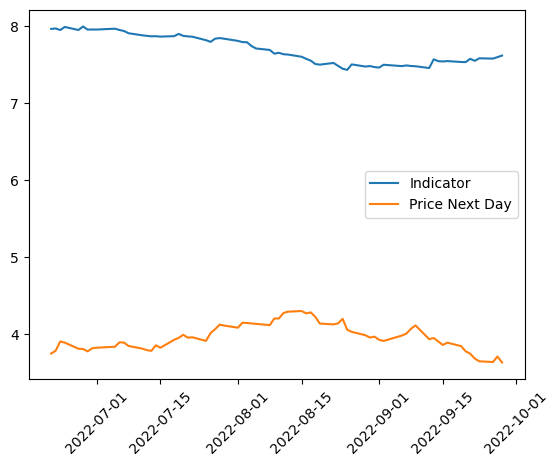

In [181]:
# Average True Range
best_period1 = None
best_corr = -np.inf
# optimize Indicator
for i in range(2, 200):
        spy_ohlc_df['indicator'] = AverageTrueRange(close=spy_ohlc_df["Close"],
                                                    high=spy_ohlc_df["High"],
                                                    low=spy_ohlc_df["Low"],
                                                    window=i).average_true_range()
        indicator = np.array(list(spy_ohlc_df['indicator'].iloc[i:train_index]))
        next_day_returns_list = list(spy_ohlc_df['Price Next Day'].iloc[i:train_index])
        result = pearsonr(indicator, next_day_returns_list)
        corr = result.statistic
        if corr > best_corr:
            best_corr = corr
            best_period1 = i
            
print("ATR Indicator")
print("Best Window:", best_period1)
print("Best Corr:", best_corr)

spy_ohlc_df['indicator'] = AverageTrueRange(close=spy_ohlc_df["Close"],
                                                    high=spy_ohlc_df["High"],
                                                    low=spy_ohlc_df["Low"],
                                                    window=best_period1).average_true_range()

plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], spy_ohlc_df['indicator'].iloc[7400:-1], 
         label="Indicator")
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], 
         spy_ohlc_df['Price Next Day'].iloc[7400:-1] / 100 , label="Price Next Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

Ulcer Index Indicator
Best Window: 9
Best Corr: 0.0790124774056689


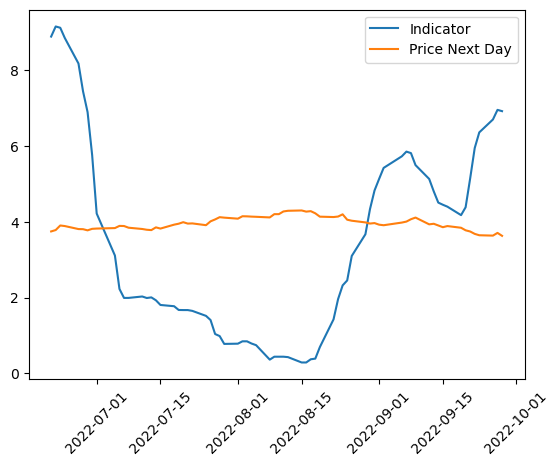

In [180]:
# UlcerIndex
best_period1 = None
best_corr = -np.inf
# optimize Indicator
for i in range(2, 200):
        spy_ohlc_df['indicator'] = UlcerIndex(close=spy_ohlc_df["Close"],
                                                    window=i).ulcer_index()
        indicator = np.array(list(spy_ohlc_df['indicator'].iloc[i:train_index]))
        next_day_returns_list = list(spy_ohlc_df['Price Next Day'].iloc[i:train_index])
        result = pearsonr(indicator, next_day_returns_list)
        corr = result.statistic
        if corr > best_corr:
            best_corr = corr
            best_period1 = i
            
print("Ulcer Index Indicator")
print("Best Window:", best_period1)
print("Best Corr:", best_corr)

spy_ohlc_df['indicator'] =UlcerIndex(close=spy_ohlc_df["Close"],
                                                    window=best_period1).ulcer_index()

plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], spy_ohlc_df['indicator'].iloc[7400:-1], 
         label="Indicator")
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], 
         spy_ohlc_df['Price Next Day'].iloc[7400:-1]/100, label="Price Next Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Trend Indicators

In [184]:
# imports needed for trend optimization
from ta.trend import ADXIndicator, AroonIndicator, CCIIndicator, DPOIndicator, \
    EMAIndicator, SMAIndicator, WMAIndicator

ADX Indicator
Best Window: 3
Best Corr: 0.00427151043952964


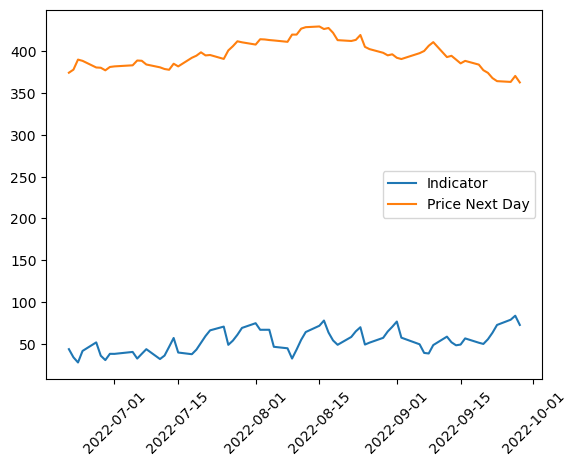

In [178]:
# ADX
best_period1 = None
best_corr = -np.inf
# optimize Indicator
for i in range(3, 200):
        spy_ohlc_df['indicator'] = ADXIndicator(close=spy_ohlc_df["Close"],
                                                high=spy_ohlc_df["High"],
                                                low=spy_ohlc_df["Low"],
                                                window=i).adx()
        indicator = np.array(list(spy_ohlc_df['indicator'].iloc[i:train_index]))
        next_day_returns_list = list(spy_ohlc_df['Price Next Day'].iloc[i:train_index])
        result = pearsonr(indicator, next_day_returns_list)
        corr = result.statistic
        if corr > best_corr:
            best_corr = corr
            best_period1 = i
            
print("ADX Indicator")
print("Best Window:", best_period1)
print("Best Corr:", best_corr)

spy_ohlc_df['indicator'] = ADXIndicator(close=spy_ohlc_df["Close"],
                                                high=spy_ohlc_df["High"],
                                                low=spy_ohlc_df["Low"],
                                                window=best_period1).adx()
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], spy_ohlc_df['indicator'].iloc[7400:-1], 
         label="Indicator")
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1],
         spy_ohlc_df['Price Next Day'].iloc[7400:-1], label="Price Next Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

Aroon Indicator
Best Window: 3
Best Corr: -0.0015910499583730244


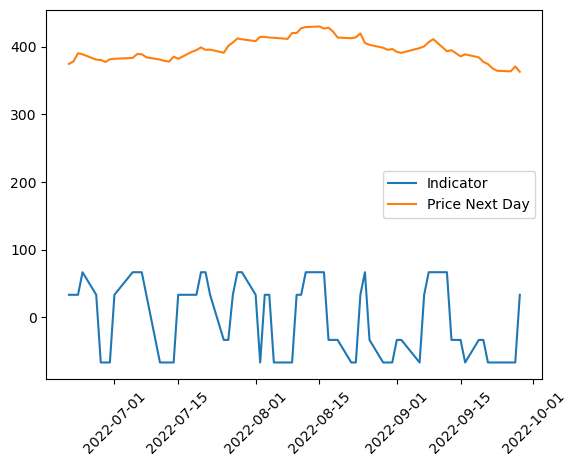

In [177]:
# AroonIndicator
best_period1 = None
best_corr = -np.inf
# optimize Indicator
for i in range(3, 200):
        spy_ohlc_df['indicator'] = AroonIndicator(close=spy_ohlc_df["Close"],
                                                window=i).aroon_indicator()
        indicator = np.array(list(spy_ohlc_df['indicator'].iloc[i:train_index]))
        next_day_returns_list = list(spy_ohlc_df['Price Next Day'].iloc[i:train_index])
        result = pearsonr(indicator, next_day_returns_list)
        corr = result.statistic
        if corr > best_corr:
            best_corr = corr
            best_period1 = i
            
print("Aroon Indicator")
print("Best Window:", best_period1)
print("Best Corr:", best_corr)

spy_ohlc_df['indicator'] = AroonIndicator(close=spy_ohlc_df["Close"],
                                                window=best_period1).aroon_indicator()
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], spy_ohlc_df['indicator'].iloc[7400:-1], 
         label="Indicator")
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], 
         spy_ohlc_df['Price Next Day'].iloc[7400:-1], label="Price Next Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

CCI Indicator
Best Window: 9
Best Corr: -0.012734404381717851


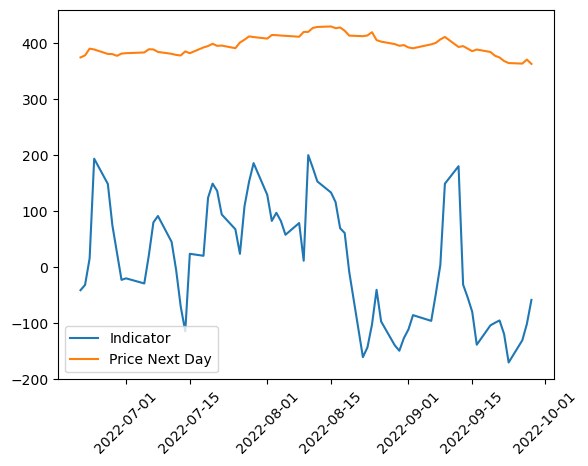

In [176]:
# CCI
best_period1 = None
best_corr = -np.inf
# optimize Indicator
for i in range(3, 200):
        spy_ohlc_df['indicator'] = CCIIndicator(close=spy_ohlc_df["Close"],
                                                high=spy_ohlc_df["High"],
                                                low=spy_ohlc_df["Low"],
                                                window=i).cci()
        indicator = np.array(list(spy_ohlc_df['indicator'].iloc[i:train_index]))
        next_day_returns_list = list(spy_ohlc_df['Price Next Day'].iloc[i:train_index])
        result = pearsonr(indicator, next_day_returns_list)
        corr = result.statistic
        if corr > best_corr:
            best_corr = corr
            best_period1 = i
            
print("CCI Indicator")
print("Best Window:", best_period1)
print("Best Corr:", best_corr)

spy_ohlc_df['indicator'] = CCIIndicator(close=spy_ohlc_df["Close"],
                                                high=spy_ohlc_df["High"],
                                                low=spy_ohlc_df["Low"],
                                                window=best_period1).cci()
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], spy_ohlc_df['indicator'].iloc[7400:-1], 
         label="Indicator")
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1],
         spy_ohlc_df['Price Next Day'].iloc[7400:-1], label="Price Next Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

DPO Indicator
Best Window: 193
Best Corr: 0.03803721263949489


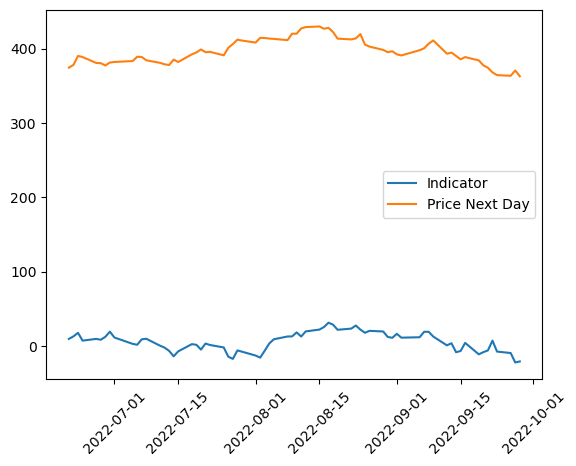

In [183]:
# DPOIndicator
best_period1 = None
best_corr = -np.inf
# optimize Indicator
for i in range(3, 200):
        spy_ohlc_df['indicator'] = DPOIndicator(close=spy_ohlc_df["Close"],
                                                window=i).dpo()
        indicator = np.array(list(spy_ohlc_df['indicator'].iloc[i:train_index]))
        next_day_returns_list = list(spy_ohlc_df['Price Next Day'].iloc[i:train_index])
        result = pearsonr(indicator, next_day_returns_list)
        corr = result.statistic
        if corr > best_corr:
            best_corr = corr
            best_period1 = i
            
print("DPO Indicator")
print("Best Window:", best_period1)
print("Best Corr:", best_corr)

spy_ohlc_df['indicator'] = DPOIndicator(close=spy_ohlc_df["Close"],
                                                window=best_period1).dpo()
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], spy_ohlc_df['indicator'].iloc[7400:-1], 
         label="Indicator")
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], 
         spy_ohlc_df['Price Next Day'].iloc[7400:-1], label="Price Next Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

EMA Indicator
Best Window: 2
Best Corr: 0.9990612195146498


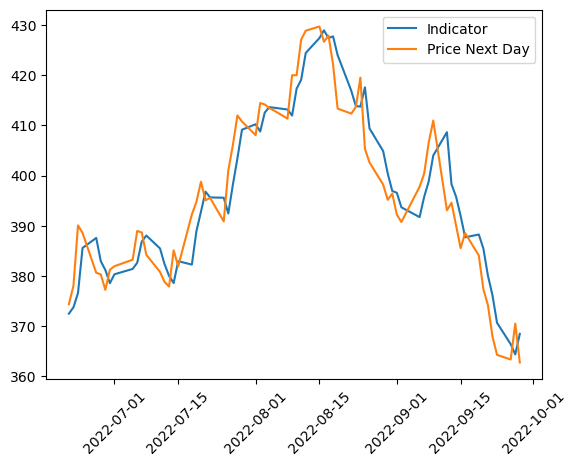

In [192]:
# EMA
best_period1 = None
best_corr = -np.inf
# optimize Indicator
for i in range(2, 200):
        spy_ohlc_df['indicator'] = EMAIndicator(close=spy_ohlc_df["Close"],
                                                window=i).ema_indicator()
        indicator = np.array(list(spy_ohlc_df['indicator'].iloc[i:train_index]))
        next_day_returns_list = list(spy_ohlc_df['Price Next Day'].iloc[i:train_index])
        result = pearsonr(indicator, next_day_returns_list)
        corr = result.statistic
        if corr > best_corr:
            best_corr = corr
            best_period1 = i
            
print("EMA Indicator")
print("Best Window:", best_period1)
print("Best Corr:", best_corr)

spy_ohlc_df['indicator'] = EMAIndicator(close=spy_ohlc_df["Close"],
                                                window=best_period1).ema_indicator()
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], spy_ohlc_df['indicator'].iloc[7400:-1], 
         label="Indicator")
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], 
         spy_ohlc_df['Price Next Day'].iloc[7400:-1], label="Price Next Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

EMA Indicator
Best Window: 2
Best Corr: 0.998949056487239


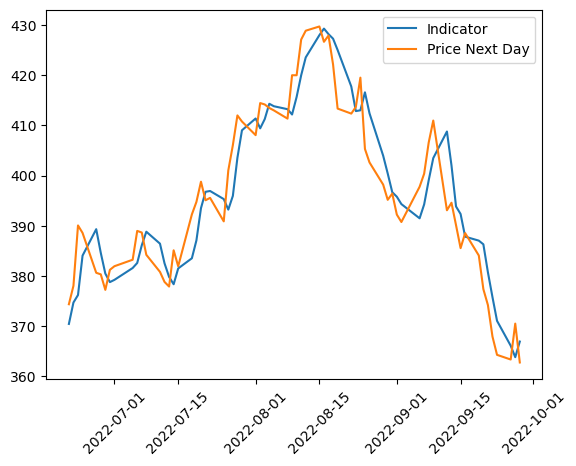

In [191]:
# SMA
best_period1 = None
best_corr = -np.inf
# optimize Indicator
for i in range(2, 200):
        spy_ohlc_df['indicator'] = SMAIndicator(close=spy_ohlc_df["Close"],
                                                window=i).sma_indicator()
        indicator = np.array(list(spy_ohlc_df['indicator'].iloc[i:train_index]))
        next_day_returns_list = list(spy_ohlc_df['Price Next Day'].iloc[i:train_index])
        result = pearsonr(indicator, next_day_returns_list)
        corr = result.statistic
        if corr > best_corr:
            best_corr = corr
            best_period1 = i
            
print("EMA Indicator")
print("Best Window:", best_period1)
print("Best Corr:", best_corr)

spy_ohlc_df['indicator'] = SMAIndicator(close=spy_ohlc_df["Close"],
                                                window=best_period1).sma_indicator()
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], spy_ohlc_df['indicator'].iloc[7400:-1], 
         label="Indicator")
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], 
         spy_ohlc_df['Price Next Day'].iloc[7400:-1], label="Price Next Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()

EMA Indicator
Best Window: 2
Best Corr: 0.9990535041665358


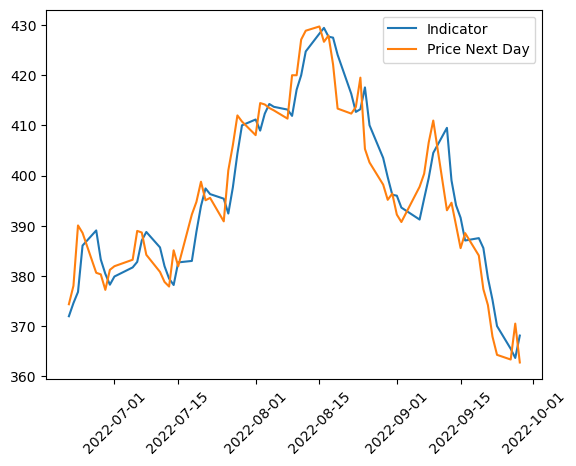

In [193]:
# WMA
best_period1 = None
best_corr = -np.inf
# optimize Indicator
for i in range(2, 200):
        spy_ohlc_df['indicator'] = WMAIndicator(close=spy_ohlc_df["Close"],
                                                window=i).wma()
        indicator = np.array(list(spy_ohlc_df['indicator'].iloc[i:train_index]))
        next_day_returns_list = list(spy_ohlc_df['Price Next Day'].iloc[i:train_index])
        result = pearsonr(indicator, next_day_returns_list)
        corr = result.statistic
        if corr > best_corr:
            best_corr = corr
            best_period1 = i
            
print("EMA Indicator")
print("Best Window:", best_period1)
print("Best Corr:", best_corr)

spy_ohlc_df['indicator'] = WMAIndicator(close=spy_ohlc_df["Close"],
                                                window=best_period1).wma()
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], spy_ohlc_df['indicator'].iloc[7400:-1], 
         label="Indicator")
plt.plot(spy_ohlc_df['Dates'].iloc[7400:-1], 
         spy_ohlc_df['Price Next Day'].iloc[7400:-1], label="Price Next Day")
plt.legend()
plt.xticks(rotation=45)
plt.show()